In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/twitter-second-app/__notebook__.ipynb
/kaggle/input/twitter-second-app/__output__.json
/kaggle/input/twitter-second-app/traindf.csv
/kaggle/input/twitter-second-app/valdf.csv
/kaggle/input/twitter-second-app/custom.css
/kaggle/input/twitter-second-app/__results__.html
/kaggle/input/twitter-second-app/__results___files/__results___3_0.png
/kaggle/input/nlp-hack/sample-submission.csv
/kaggle/input/nlp-hack/train.csv
/kaggle/input/nlp-hack/test.csv


In [2]:
%matplotlib inline
import os, sys
import re
import string
import pathlib
import random
from collections import Counter, OrderedDict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from tqdm import tqdm, tqdm_notebook, tnrange
tqdm.pandas(desc='Progress')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

import torchtext
from torchtext import data
from torchtext import vocab

from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import accuracy_score

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
df=pd.read_csv('../input/nlp-hack/train.csv')
df.shape
df.head()

(1280000, 5)

,Id,date,user,text,target
0,0,Fri Jun 05 22:04:23 PDT 2009,JGoldsborough,"@jbtaylor WIth ya. &quot;I'd like a Palm Pre, ...",4
1,1,Sat Jun 06 03:12:21 PDT 2009,Psioui,"felt the earthquake this afternoon, it seems t...",4
2,2,Sat May 30 19:02:49 PDT 2009,adriville,"Ruffles on shirts are like so in, me Likey",4
3,3,Thu Jun 25 05:59:18 PDT 2009,Blondie128,Pretty bad night into a crappy morning....FML!...,0
4,4,Sat May 30 11:16:35 PDT 2009,khrabrov,"@dcbriccetti yeah, what a clear view!",4


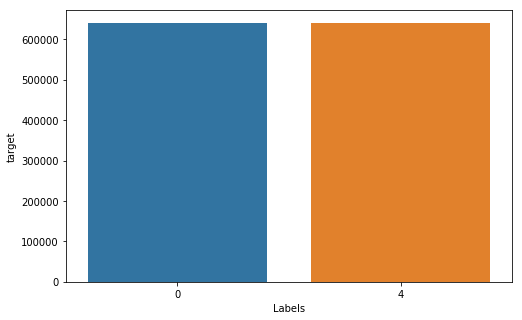

In [4]:
fig = plt.figure(figsize=(8,5))
ax = sns.barplot(x=df.target.unique(),y=df.target.value_counts());
ax.set(xlabel='Labels');

In [5]:
df['text'] = df.text.progress_apply(lambda x: re.sub('\n', ' ', x))

Progress: 100%|██████████| 1280000/1280000 [00:02<00:00, 479121.53it/s]


In [6]:
def split_train_test(df, test_size=0.2):
    train, val = train_test_split(df, test_size=test_size,random_state=42)
    return train.reset_index(drop=True), val.reset_index(drop=True)

In [7]:
traindf, valdf = split_train_test(df, test_size=0.2)

In [8]:
traindf.shape
traindf.head()
traindf.text.value_counts()

(1024000, 5)

,Id,date,user,text,target
0,263132,Fri May 29 09:37:27 PDT 2009,dawgs52,@laurenvdw ahh when i was there it was closed,0
1,615448,Sat Jun 06 21:51:09 PDT 2009,Imelbing,Having an awesome lunch w/ mom &amp; bro - yum...,4
2,158240,Tue Jun 16 17:49:15 PDT 2009,cutthroatpixie,#IMISSCATH #IMISSCATH #IMISSCATH #IMISSCATH #...,0
3,1218246,Sun Apr 19 07:09:48 PDT 2009,Meroko,@reikifurbabies Good morning beautiful one!,4
4,414653,Mon Apr 20 23:26:02 PDT 2009,Mehita,cracked open the first chapter of something ol...,4


isPlayer Has Died! Sorry                                                                                                                 134
good morning                                                                                                                              73
Headache                                                                                                                                  73
headache                                                                                                                                  69
Good morning                                                                                                                              62
Goodnight                                                                                                                                 59
 cant afford to see Angels and Demons, so i watched it for free: http://tr.im/lvBu                                                        58
Jogging, isnt

In [9]:
valdf.shape
valdf.head()
valdf.text.value_counts()

(256000, 5)

,Id,date,user,text,target
0,598756,Tue Jun 02 21:44:56 PDT 2009,danrom81,Heat Brought to you by the letter F: Summer ...,4
1,1103804,Wed Jun 17 08:31:33 PDT 2009,debbeaton,missing the days I felt you inside of me.,0
2,1192002,Mon May 18 07:19:52 PDT 2009,Nick7782,@rebeccao372 oh dear xx she not well?,0
3,71502,Sat May 30 00:10:49 PDT 2009,MissAddict,@ChalkBored Thank you I love bright colours. ...,4
4,1069136,Fri Jun 05 23:27:04 PDT 2009,billygee12,'Thinking about eating another doughnut.,4


isPlayer Has Died! Sorry                                                                                                                 33
headache                                                                                                                                 22
Good morning                                                                                                                             20
good morning                                                                                                                             18
Need to send emails to 100,000  contacts? Check out EmailUnlimited on http://www.4officeautomation.com                                   18
Not to worry, noone got that one. Next question starts in 1 minute, get your thinking caps on                                            18
my tummy hurts                                                                                                                           16
 cant afford to see 

In [10]:
traindf.to_csv('traindf.csv', index=False)#
valdf.to_csv('valdf.csv', index=False)

In [11]:

nlp = spacy.load('en',disable=['parser', 'tagger', 'ner'])
def tokenizer(s): return [w.text.lower() for w in nlp(tweet_clean(s))]

In [12]:
def tweet_clean(text):
    text = re.sub(r'[^A-Za-z0-9]+', ' ', text) # remove non alphanumeric character
    text = re.sub(r'https?:/\/\S+', ' ', text) # remove links
    return text.strip()

In [13]:
txt_field = data.Field(sequential=True, tokenize=tokenizer, include_lengths=True, use_vocab=True)
label_field = data.Field(sequential=False, use_vocab=False, pad_token=None, unk_token=None)

train_val_fields = [
    ('Id', None),
    ('target', label_field),
    ('user', None),
    ('text', txt_field)
]

In [14]:
df1=pd.read_csv('/kaggle/input/Twitter-second-app/traindf.csv')
len(df1)

FileNotFoundError: File b'/kaggle/input/Twitter-second-app/traindf.csv' does not exist

In [15]:
#%%time
trainds, valds = data.TabularDataset.splits(path='/kaggle/input/twitter-second-app', format='csv', train='traindf.csv',
                                            validation='valdf.csv', fields=train_val_fields, skip_header=True)